# Import libraries

In [1]:
# Import required libraries
import pandas as pd
import wrds
from fuzzywuzzy import fuzz, process
import os
from dotenv import load_dotenv
import sqlite3

In [13]:
# Load the .env file
load_dotenv()

True

# Select S&P1500 companies

We open the Execucomp list of companies from 2022 to 2023. 
Select all the unique gvkeys and save them in a list.

In [14]:
# Connect to WRDS database
def connect_wrds():
    # Get WRDS username and password from environment variables
    wrds_username = os.getenv("WRDS_USERNAME")
    wrds_password = os.getenv("WRDS_PASSWORD")
    # Establish a connection to the WRDS database
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    return db


In [15]:
# Download executive compensation data from WRDS database
def download_gvkeys_execucomp(db, start_year=2022, end_year=2022):
    # SQL query to select specific columns for CEO records from a specific year range
    query = f"""
        SELECT gvkey, year
        FROM  comp_execucomp.anncomp
        WHERE year BETWEEN {start_year} AND {end_year}
    """
    # Execute the SQL query and load the result into a pandas DataFrame
    anncomp_data = db.raw_sql(query)
    anncomp_data = anncomp_data.drop_duplicates(subset=['gvkey'])
    anncomp_data = anncomp_data[anncomp_data['gvkey'].notna()]
    anncomp_data['gvkey'] = anncomp_data['gvkey'].astype(int)
    # list of gvkeys
    gvkey_list = anncomp_data['gvkey'].tolist()
    return gvkey_list

In [16]:
    # Download executive compensation data from WRDS
db = connect_wrds()
sxp1500_gvkeys = download_gvkeys_execucomp(db)
db.close()

Loading library list...
Done


In [17]:
sxp1500_gvkeys = pd.DataFrame(sxp1500_gvkeys, columns=['gvkey'])

In [18]:
sxp1500_gvkeys.to_csv('../data/sxp1500_gvkeys.csv', index=False)

## Get companyID list for GVKEYs

In [ ]:
gvkey_companyid_map = pd.read_csv("../data/transcripts_raw_v2/gvkey_companyid_map.csv")

In [20]:
gvkey_companyid_map

,companyid,gvkey,startdate,enddate,companyname
0,18507,235716,B,E,2M Invest A/S
1,18511,210835,B,E,3i Group plc
2,18527,210418,B,E,ABB Ltd
3,18671,29751,B,E,Albemarle Corporation
4,18711,28349,B,E,The Allstate Corporation
...,...,...,...,...,...
125789,1826158803,356171,B,E,"Logory Logistics Technology Co., Ltd."
125790,1826280776,356134,B,E,PT Petrindo Jaya Kreasi Tbk
125791,1826705821,356208,B,E,ADNOC Gas plc
125792,1828304836,63029,2023-02-24,E,EKIMAS Corporation


In [21]:
# if there are multiple gvkeys for a company, keep the one with the most recent startdate, or the one without an enddate if there is no startdate, or the one with the latest enddate if there is no startdate and no observation without an enddate
gvkey_companyid_map = gvkey_companyid_map.sort_values(by=['gvkey', 'enddate', 'startdate'], ascending=[True, True, True])

In [22]:
gvkey_companyid_map = gvkey_companyid_map.drop_duplicates(subset=['gvkey'], keep='last')
gvkey_companyid_map = gvkey_companyid_map.drop(columns=['startdate', 'enddate'])


In [23]:
sxp1500_gvkeys

,gvkey
0,1004
1,1045
2,1075
3,1076
4,1078
...,...
1743,294524
1744,316056
1745,317264
1746,326688


In [24]:
sxp1500_gvkeys_companyid = pd.merge(sxp1500_gvkeys, gvkey_companyid_map, how='left', on='gvkey')

In [25]:
sxp1500_gvkeys_companyid

,gvkey,companyid,companyname
0,1004,168154.0,AAR Corp.
1,1045,168569.0,American Airlines Group Inc.
2,1075,296957.0,Pinnacle West Capital Corporation
3,1076,247226.0,"PROG Holdings, Inc."
4,1078,247483.0,Abbott Laboratories
...,...,...,...
1743,294524,792424.0,LyondellBasell Industries N.V.
1744,316056,241782379.0,Allegion plc
1745,317264,243058659.0,Dorian LPG Ltd.
1746,326688,542155250.0,nVent Electric plc


In [26]:
# drop if companyid is null
sxp1500_gvkeys_companyid = sxp1500_gvkeys_companyid[sxp1500_gvkeys_companyid['companyid'].notna()]

In [27]:
sxp1500_gvkeys_companyid.columns

Index(['gvkey', 'companyid', 'companyname'], dtype='object')

In [28]:
sxp1500_gvkeys_companyid.to_csv("../data/sxp1500_gvkeys.csv", index=False)

# Pull transcripts for SXP1500 companies

In [29]:
# Create a connection to the SQLite database (it will create a new one if it doesn't exist)
# list the tables in the database
conn = sqlite3.connect('../data/transcripts_raw_v2/transcripts_data.db')

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('transcripts_2004',), ('transcripts_2005',), ('transcripts_2006',), ('transcripts_2007',), ('transcripts_2008',), ('transcripts_2009',), ('transcripts_2010',), ('transcripts_2011',), ('transcripts_2012',), ('transcripts_2013',), ('transcripts_2014',), ('transcripts_2015',), ('transcripts_2016',), ('transcripts_2017',), ('transcripts_2018',), ('transcripts_2019',), ('transcripts_2020',), ('transcripts_2021',), ('transcripts_2022',), ('transcripts_2023',)]


In [30]:
# Execute the PRAGMA statement
cursor.execute("PRAGMA table_info(transcripts_2009);")

# Fetch all the rows
columns = cursor.fetchall()

# Print each column name
for column in columns:
    print(column[1])

companyid
keydevid
transcriptid
headline
mostimportantdateutc
mostimportanttimeutc
keydeveventtypeid
keydeveventtypename
companyname
transcriptcollectiontypeid
transcriptcollectiontypename
transcriptpresentationtypeid
transcriptpresentationtypename
transcriptcreationdate_utc
transcriptcreationtime_utc
audiolengthsec
isdelayed_flag
delayreasontypeid
delayreasontypename
transcriptcomponentid
componentorder
transcriptcomponenttypeid
transcriptcomponenttypename
transcriptpersonid
transcriptpersonname
proid
companyofperson
speakertypeid
speakertypename
componenttextpreview
word_count
componenttext


## Get all presentation segments

Get speaker segment for each transcript, keep only if transcriptid is in gvkey_companyid_map

Three conditions:\
    'keydeveventtypeid' == 48  event is earnings call \
    'transcriptcomponentTypeId' == 2  component is presentation \
    'speakertypeid'==2 speaker is executive \
    'transcriptpresentationtypeid' == 5 is proofread


In [31]:

# Create a connection to the SQLite database
conn = sqlite3.connect('../data/transcripts_raw_v2/transcripts_data.db')
cursor = conn.cursor()

# Retrieve the list of tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Extract table names from the query result
table_names = [table[0] for table in tables]

# Create a temporary table for company IDs
cursor.execute("CREATE TEMPORARY TABLE temp_companyids (companyid INTEGER);")  # Replace TYPE with the actual type of your companyid

# Insert company IDs into the temporary table
company_ids = sxp1500_gvkeys_companyid['companyid'].tolist()
cursor.executemany("INSERT INTO temp_companyids (companyid) VALUES (?);", [(id,) for id in company_ids])

# Commit the changes
conn.commit()



In [32]:

# Define the selection criteria
criteria = """
WHERE keydeveventtypeid = 48 AND 
      transcriptcomponenttypeid = 2 AND
      speakertypeid = 2
"""

# Create a list to store DataFrame chunks
df_chunks = []

# Loop through each table and apply the criteria
for table_name in table_names:
    print('working on table: ', table_name)
    # SQL query to select matching rows using an INNER JOIN with the temporary table and a subquery
    query = f"""
    SELECT t.* FROM {table_name} t
    INNER JOIN temp_companyids tc ON t.companyid = tc.companyid
    INNER JOIN (
        SELECT keydevid, MAX(transcriptid) as max_transcriptid
        FROM {table_name}
        GROUP BY keydevid
    ) tm ON t.keydevid = tm.keydevid AND t.transcriptid = tm.max_transcriptid
    {criteria}
    """
    
    # Execute the query
    df_chunk = pd.read_sql_query(query, conn)
    
    # Append to the main DataFrame
    df_chunks.append(df_chunk)

sxp1500_presentations = pd.concat(df_chunks, ignore_index=True)

# Close the connection to the database
conn.close()

# Output the resulting DataFrame
sxp1500_presentations.head()

working on table:  transcripts_2004
working on table:  transcripts_2005
working on table:  transcripts_2006
working on table:  transcripts_2007
working on table:  transcripts_2008
working on table:  transcripts_2009
working on table:  transcripts_2010
working on table:  transcripts_2011
working on table:  transcripts_2012
working on table:  transcripts_2013
working on table:  transcripts_2014
working on table:  transcripts_2015
working on table:  transcripts_2016
working on table:  transcripts_2017
working on table:  transcripts_2018
working on table:  transcripts_2019
working on table:  transcripts_2020
working on table:  transcripts_2021
working on table:  transcripts_2022
working on table:  transcripts_2023


,companyid,keydevid,transcriptid,headline,mostimportantdateutc,mostimportanttimeutc,keydeveventtypeid,keydeveventtypename,companyname,transcriptcollectiontypeid,...,transcriptcomponenttypename,transcriptpersonid,transcriptpersonname,proid,companyofperson,speakertypeid,speakertypename,componenttextpreview,word_count,componenttext
0,119902.0,2386930.0,364.0,"Autodesk, Inc., Q3 2006 Earnings Call, Nov-17-...",2005-11-17,22:00:00.000000,48.0,Earnings Calls,"Autodesk, Inc.",6,...,Presenter Speech,18111.0,Sue Pirri,None,None,2,Executives,"Thanks, operator. Good afternoon everyone. Tha...",313.0,"Thanks, operator. Good afternoon everyone. Tha..."
1,119902.0,2386930.0,364.0,"Autodesk, Inc., Q3 2006 Earnings Call, Nov-17-...",2005-11-17,22:00:00.000000,48.0,Earnings Calls,"Autodesk, Inc.",6,...,Presenter Speech,17554.0,Carl Bass,None,None,2,Executives,Good afternoon and thank you for joining us. T...,802.0,Good afternoon and thank you for joining us. T...
2,119902.0,2386930.0,364.0,"Autodesk, Inc., Q3 2006 Earnings Call, Nov-17-...",2005-11-17,22:00:00.000000,48.0,Earnings Calls,"Autodesk, Inc.",6,...,Presenter Speech,17453.0,Al Castino,None,None,2,Executives,"And thanks, Carl. Once again, Autodesk deliver...",1098.0,"And thanks, Carl. Once again, Autodesk deliver..."
3,119902.0,2386930.0,364.0,"Autodesk, Inc., Q3 2006 Earnings Call, Nov-17-...",2005-11-17,22:00:00.000000,48.0,Earnings Calls,"Autodesk, Inc.",6,...,Presenter Speech,17554.0,Carl Bass,None,None,2,Executives,"Thanks, Al. Before we take questions, I'd like...",203.0,"Thanks, Al. Before we take questions, I'd like..."
4,332273.0,2390202.0,395.0,"American Eagle Outfitters, Inc., Q3 2006 Earni...",2005-11-15,14:00:00.000000,48.0,Earnings Calls,"American Eagle Outfitters, Inc.",6,...,Presenter Speech,21952.0,Judy Meehan,None,None,2,Executives,"Good morning, everybody. Thank you for joining...",127.0,"Good morning, everybody. Thank you for joining..."


Merge with companyid map to add gveky

In [33]:
sxp1500_gvkeys_companyid = sxp1500_gvkeys_companyid[['gvkey', 'companyid']]

In [ ]:
sxp1500_gvkeys_companyid = sxp1500_gvkeys_companyid.drop_duplicates(subset=['gvkey'])
sxp1500_gvkeys_companyid = sxp1500_gvkeys_companyid.drop_duplicates(subset=['companyid'])

In [35]:
sxp1500_presentations = sxp1500_presentations.merge(sxp1500_gvkeys_companyid, how='left', on='companyid')

In [36]:
sxp1500_presentations.shape

(343584, 33)

In [37]:
sxp1500_presentations.to_pickle("../data/sxp1500_presentations.pkl")

In [ ]:
sxp1500_presentations = pd.read_pickle("../data/sxp1500_presentations.pkl")

### Some sanity checks

In [ ]:
# check number of unique firms
sxp1500_presentations['companyid'].nunique()

1691

In [ ]:
# average number of transcripts per firm
sxp1500_presentations.groupby('companyid')['transcriptid'].nunique().mean()


53.28089887640449

In [ ]:
# average number of transcripts per firm per year
sxp1500_presentations['year'] = sxp1500_presentations['mostimportantdateutc'].str[:4]
sxp1500_presentations.groupby(['companyid', 'year'])['transcriptid'].nunique().mean()


3.7506452418616267

In [ ]:
# select only groups where for a given keydevid, there are more than 1 unique transcriptid

test = sxp1500_presentations.copy()

In [43]:
test['transcriptunique'] = test.groupby(['companyid', 'keydevid'])['transcriptid'].transform('nunique')

In [44]:
test[test['transcriptunique']>1].shape

(0, 35)

In [ ]:
# keep only the highest transcriptid per devid
sxp1500_presentations_ids = sxp1500_presentations.groupby('keydevid')['transcriptid'].transform('max')

# Then, we filter the dataframe to keep only the rows where the employee ID matches the maximum ID
sxp1500_presentations = sxp1500_presentations[sxp1500_presentations['transcriptid'] == sxp1500_presentations_ids]


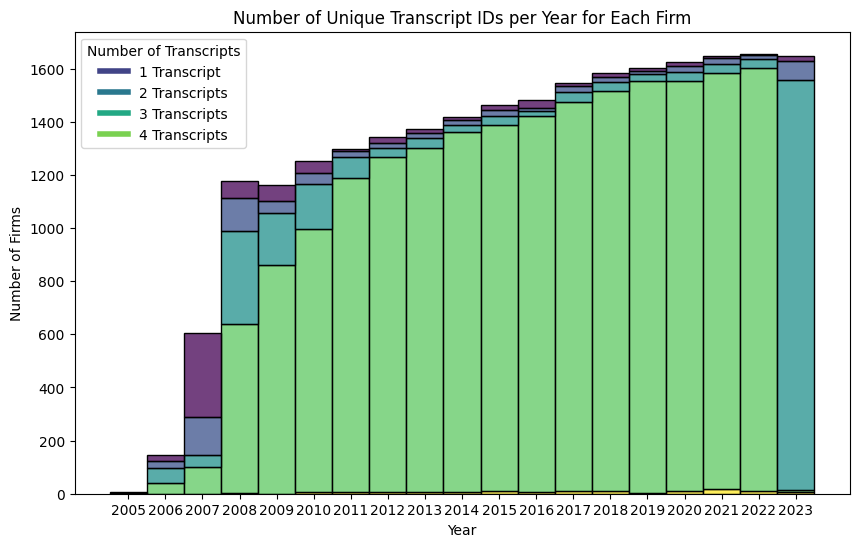

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Group by companyid and year, then count unique transcriptids
transcript_counts = sxp1500_presentations.groupby(['companyid', 'year'])['transcriptid'].nunique()

# Reset index to convert groupby object to DataFrame
transcript_counts = transcript_counts.reset_index()

# Rename columns for clarity
transcript_counts.columns = ['companyid', 'year', 'num_transcripts']

# Limit the number of transcripts to 5 for the plot
transcript_counts['num_transcripts'] = transcript_counts['num_transcripts'].clip(upper=5)

# Sort the dataframe by year
transcript_counts = transcript_counts.sort_values(by='year')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.histplot(data=transcript_counts, x='year', hue='num_transcripts', multiple='stack', palette='viridis')

plt.title('Number of Unique Transcript IDs per Year for Each Firm')
plt.xlabel('Year')
plt.ylabel('Number of Firms')

# Create a custom legend to explain what each color represents
num_transcripts_legend = [plt.Line2D([0], [0], color=sns.color_palette('viridis', 4)[i], lw=4) for i in range(4)]
plt.legend(num_transcripts_legend, ['1 Transcript', '2 Transcripts', '3 Transcripts', '4 Transcripts'], title='Number of Transcripts', loc='upper left')

plt.show()



# Identify CEO speakers

In [47]:
# Connect to WRDS database
def connect_wrds():
    # Get WRDS username and password from environment variables
    wrds_username = os.getenv("WRDS_USERNAME")
    wrds_password = os.getenv("WRDS_PASSWORD")
    # Establish a connection to the WRDS database
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    return db


# Download executive compensation data from WRDS database
def download_anncomp_data(db, start_year=2006, end_year=2023):
    # SQL query to select specific columns for CEO records from a specific year range
    query = f"""
        SELECT gvkey, exec_fullname, execid, year
        FROM  comp_execucomp.anncomp
        WHERE ceoann='CEO' AND year BETWEEN {start_year} AND {end_year}
    """
    # Execute the SQL query and load the result into a pandas DataFrame
    anncomp_data = db.raw_sql(query)
    anncomp_data['gvkey'] = anncomp_data['gvkey'].astype(int)
    return anncomp_data


# Data preprocessing
def create_year_column(input_df, date_col='mostimportantdateutc'):
    # Add a new column "year" to the DataFrame, derived from the "mostimportantdateutc" column
    input_df.loc[:, 'year'] = pd.to_datetime(input_df[date_col]).dt.year
    return input_df


# Fuzzy matching
def match_executives(name1, name2):
    # Use fuzzy matching to compare similarity between two executive names
    return fuzz.token_set_ratio(name1, name2)


def fuzzy_merge(df1, df2, gvkey_col='gvkey', year_col='year', name_col1='exec_fullname',
                name_col2='transcriptpersonname', threshold=85):
    # Helper function to find the best match
    def find_best_match(row, candidates):
        row[name_col2] = "" if pd.isnull(row[name_col2]) else row[name_col2]
        candidates = candidates.fillna("")
        if not row[name_col2] or all(not candidate for candidate in candidates):
            return None
        best_match, score, *_ = process.extractOne(row[name_col2], candidates)
        if score >= threshold:
            return best_match
        else:
            return None

    # Convert the 'gvkey' columns to string data type
    df1[gvkey_col] = df1[gvkey_col].astype(int)
    df2[gvkey_col] = df2[gvkey_col].astype(int)

    # Group the data by 'year' and 'gvkey'
    grouped_df2 = df2.groupby([year_col, gvkey_col])

    # Perform fuzzy matching within each group
    matched_names = []
    for idx, row in df1.iterrows():
        year = row[year_col]
        gvkey = row[gvkey_col]
        # Note: there might be some mismatches if the ceo leaves midyear. Not sure how the data behaves in that case.
        if (year, gvkey) in grouped_df2.groups:
            candidates = grouped_df2.get_group((year, gvkey))[name_col1]
            matched_name = find_best_match(row, candidates)
        else:
            matched_name = None
        matched_names.append(matched_name)

    # Add the matched names to the DataFrame
    df1['matched_name'] = matched_names

    # Merge the two DataFrames based on 'gvkey', 'year' and 'matched_name'
    merged_df = pd.merge(
        df1,
        df2,
        left_on=[gvkey_col, year_col, 'matched_name'],
        right_on=[gvkey_col, year_col, name_col1],
        how='left'
    )

    # Add the 'is_ceo' column with True if the names match and False otherwise
    merged_df['is_ceo'] = merged_df['matched_name'].notnull()

    return merged_df



In [ ]:
# Load your input dataframe, for example from a CSV file
sxp1500_presentations = pd.read_pickle("../data/sxp1500_presentations.pkl")

db = connect_wrds()

# Download executive compensation data from WRDS
anncomp_data = download_anncomp_data(db)

# Preprocess input DataFrame
input_df = create_year_column(sxp1500_presentations)


Loading library list...
Done


In [49]:

# Perform fuzzy matching and merge the DataFrames
merged_df = fuzzy_merge(input_df, anncomp_data)

### Some sanity checks

In [50]:
test = merged_df[merged_df['is_ceo']==True]
test = test[['transcriptpersonname', 'exec_fullname', 'matched_name', 'is_ceo']]

what percent of transcripts have a CEO speaker?

In [51]:
grouped_df = merged_df.groupby('transcriptid')
has_ceo = grouped_df['is_ceo'].any()

percentage_ceo_speakers = (has_ceo.sum() / len(grouped_df)) * 100
percentage_ceo_speakers



86.05123537638465

In [52]:

# Save the merged dataframe to a file, for example, a CSV file
merged_df.to_pickle("../data/sxp1500_presentations_ceo.pkl")


# Exploratory data analysis

In [2]:
db = pd.read_pickle("../data/sxp1500_presentations_ceo.pkl")


In [8]:
db = db[db['year']>=2010]
db = db[db['year']<=2022]

In [9]:
db.gvkey.nunique()

1685

In [10]:
db.transcriptid.nunique()

75581

In [11]:
db[db['is_ceo']==1].transcriptid.nunique()

69248